In [73]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

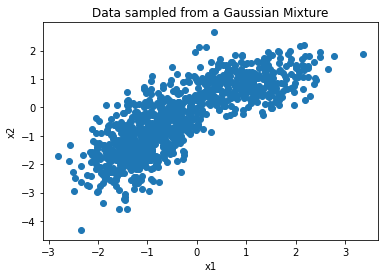

In [74]:
#Generating my own data
#Tweak these to get other plots. 
tru_mu_1 = [-1, -1]
tru_mu_2 = [1, 0.8]
tru_Sigma_1 = [[0.36, 0.31], [0.31, 0.754]]
tru_Sigma_2 = [[0.5, 0.143], [0.143, 0.3]]
tru_pi_1 = 0.65
true_pi_2 = 1-tru_pi_1
no_of_points = 1000
no_of_first_gaussian = np.sum(st.bernoulli.rvs(p = tru_pi_1, size = no_of_points))
distribution_1_points = st.multivariate_normal(tru_mu_1, tru_Sigma_1).rvs(size = no_of_first_gaussian)
distribution_2_points = st.multivariate_normal(tru_mu_2, tru_Sigma_2).rvs(size = no_of_points - no_of_first_gaussian)
X = np.concatenate([distribution_1_points, distribution_2_points], axis = 0)
plt.scatter(X[:,0], X[:, 1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Data sampled from a Gaussian Mixture")
plt.show()

In [75]:
#data = pd.read_csv("unlabeled.csv")
#X = data[["x1", "x2"]].values
#X_1 = X[:, 0]
#X_2 = X[:, 1]
#plt.scatter(X_1, X_2)
#plt.title("Data Set")
#plt.xlabel("x1")
#plt.ylabel("x2")
#plt.show()

In [76]:
#The expectation step where we find out the gammas/posteriors
def expectation_step(pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2, X):
    Likely_1 = (st.multivariate_normal(mu_1, Sigma_1).pdf(X)).reshape(-1,1)     
    #The ith row element is the likelihood P(X^i |z^j_1 = 1,mu_1,Sigma_1)
    Likely_2 = (st.multivariate_normal(mu_2, Sigma_2).pdf(X)).reshape(-1,1)    
    #The ith row element is the likelihood P(X^i |z^j_2 = 1,mu_2,Sigma_2)
    A = np.concatenate([pi_1*Likely_1, pi_2*Likely_2], axis = 1)
    Gammas = A/(np.sum(A, axis = 1)).reshape(-1, 1)          
    #The jth row ith column is gamma(z^{(j)}_i) = P(z^{(j)}_i = 1|x^{(j)})
    return Gammas

In [77]:
#The maximization step where we find out the maximizers and new parameters. 
def maximization_step(X, Gammas):
    N, dummy = X.shape
    pi_1 = np.sum(Gammas[:, 0])/N
    pi_2 = np.sum(Gammas[:, 1])/N   #or just 1 - pi_1
    mu_1 = (X.T@Gammas[:, 0])/np.sum(Gammas[:, 0])
    mu_2 = (X.T@Gammas[:, 1])/np.sum(Gammas[:, 1])
    centered_vects_1 = X.T - (mu_1).reshape(-1,1)
    centered_vects_2 = X.T - (mu_2).reshape(-1,1)
    D_1 = np.zeros((N,N))
    np.fill_diagonal(D_1, Gammas[:, 0])
    D_2 = np.zeros((N, N))
    np.fill_diagonal(D_2, Gammas[:, 1])
    Sigma_1 = ((centered_vects_1@D_1)@(centered_vects_1.T))/np.sum(Gammas[:, 0])
    Sigma_2 = ((centered_vects_2@D_2)@(centered_vects_2.T))/np.sum(Gammas[:, 1])
    return pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2

In [78]:
#We calculate the log likelihood of our current model and use it for the stopping criterion. 
def log_likelihood(pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2, X):
    Likely_1 = (st.multivariate_normal(mu_1, Sigma_1).pdf(X)).reshape(-1,1)
    Likely_2 = (st.multivariate_normal(mu_2, Sigma_2).pdf(X)).reshape(-1,1)
    pis = [pi_1, pi_2]
    Log_Likelihoods = np.log(np.concatenate([Likely_1, Likely_2], axis = 1)@pis)
    Log_Likelihood = np.sum(Log_Likelihoods)
    return Log_Likelihood


In [79]:
#We put all the functions together and loop through the EM algorithm. The stopping criterion is when the log likelihoods begin to settle around a value, i.e, when the (absolute) difference between two iterations is small enough. 
def train(pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2, X, stop_crit):
    log_likelihoods = []
    log_likelihoods.append(log_likelihood(pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2, X))
    count = 0
    while True:
        Gammas = expectation_step(pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2, X)
        pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2 = maximization_step(X, Gammas)
        log_likelihoods.append(log_likelihood(pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2, X))
        if (len(log_likelihoods)>2 and np.abs(log_likelihoods[-1]-log_likelihoods[-2]) < stop_crit):
            break
        count = count + 1
    return pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2, log_likelihoods


In [80]:
#We'll initialize with a good "guess" to speed up the process; due to the correctness of the EM algorithm however, we should settle at an optimum regardless of our initial guess. This is for readability.
mu_1 = [3, -1]
Sigma_1 = [[2, 0], [0, 2]]
mu_2 = [4, -2]
Sigma_2 = [[1, 0], [0, 2]]
pi_1 = 0.6
pi_2 = 1-pi_1

In [81]:
pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2, log_likelihoods = train(pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2, X, 0.0001)

In [82]:
#This is the probability density of the parameters we learnt using the EM method.
def f(input_1, input_2, pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2):
    x = np.column_stack([input_1.ravel(), input_2.ravel()])
    densities = pi_1*st.multivariate_normal(mu_1, Sigma_1).pdf(x) + pi_2*st.multivariate_normal(mu_2, Sigma_2).pdf(x)
    return densities

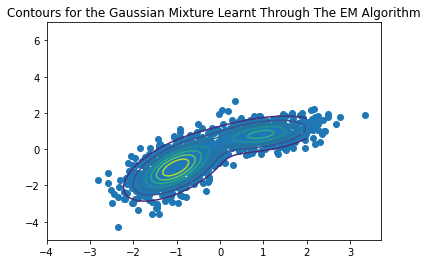

In [83]:
s = 200
x_s = np.linspace(-4, 2, s)
y_s = np.linspace(-5, 7, s)
X_s, Y_s = np.meshgrid(x_s, y_s)
Z = np.reshape(f(X_s, Y_s, pi_1, pi_2, mu_1, mu_2, Sigma_1, Sigma_2), (s, s))
plt.scatter(X[:,0], X[:, 1])
plt.contour(X_s, Y_s, Z)
plt.title("Contours for the Gaussian Mixture Learnt Through The EM Algorithm")
plt.show()

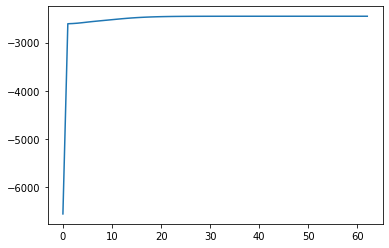

In [84]:
plt.plot(log_likelihoods)
plt.show()